In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [129]:
# import requests
# # https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/
# url = 'http://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz'
# target_path = '/kaggle/working/BreaKHis_v1.tar.gz'

# response = requests.get(url, stream=True)
# if response.status_code == 200:
#     with open(target_path, 'wb') as f:
#         f.write(response.raw.read())
# !wget http://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz
!tar -xzf BreaKHis_v1.tar.gz -C .
# !mv /kaggle/working/BreaKHis_v1/BreaKHis_v1/ /kaggle/working/

In [155]:
# !ls BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X
!ls BreaKHis_v1/histology_slides/breast/
!cat BreaKHis_v1/histology_slides/breast/README.txt

README.txt  benign  count_files.sh  malignant
Samples
* Samples are generated from breast tissue biopsy slides,
stained with hematoxylin and eosin (HE).
* prepared for histological study and labelled by pathologists of the P&D Lab
* breast tumor specimens assessed by Immunohistochemistry (IHC)
* Core Needle Biopsy (CNB) and Surgical Open Biopsy (SOB)
* section of ~3µm thickness

Image acquisition
* Olympus BX-50 system microscope with a relay lens with magnification of 3.3× coupled to a Samsung digital color camera SCC-131AN
* magnification 40×, 100×, 200×, and 400× (objective lens 4×, 10×, 20×, and 40× with ocular lens 10×)
* camera pixel size 6.5 µm
* raw images without normalization nor color color standardization
* resulting images saved in 3-channel RGB, 8-bit depth in each channel, PNG format


Format of image filename

   <BIOPSY_PROCEDURE>_<TUMOR_CLASS>_<TUMOR_TYPE>_<YEAR>-<SLIDE_ID>-<MAGNIFICATION>-<SEQ>

   <BIOPSY_PROCEDURE>::=CNB|SOB
   <TUMOR_CLASS>::=M|B
   <TUMOR_TYPE>::

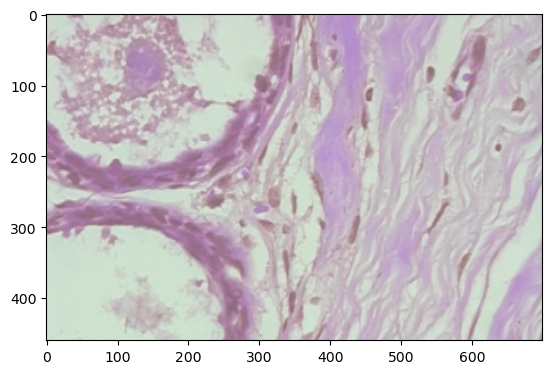

In [149]:
# img = cv2.imread("./BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/400X/SOB_B_A-14-22549AB-400-003.png")
img = cv2.imread("./BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-032.png")
# extract label from image


plt.imshow(img)
plt.show()

In [21]:
data_dir = "/kaggle/input/oxml-carinoma-classification"
image_paths = [f"{data_dir}/{fname}" for fname in os.listdir(data_dir) if "png" in fname]
image_paths[0:1]

['/kaggle/input/oxml-carinoma-classification/img_701568.png']

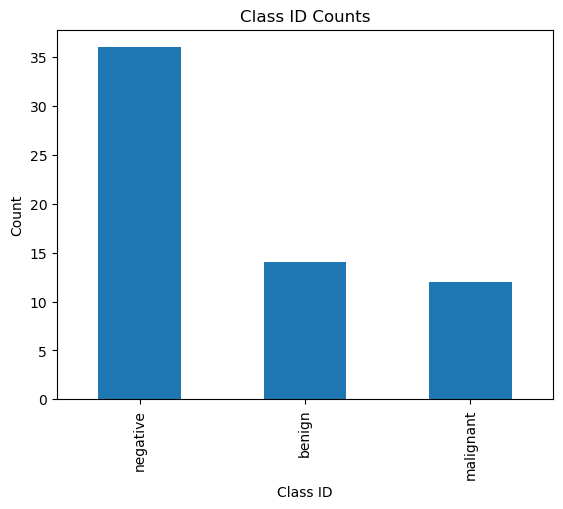

In [22]:
label_path = [f"{data_dir}/{fname}" for fname in os.listdir(data_dir) if "csv" in fname][0]
labels_df = pd.read_csv(label_path)
# bring into different form
expanded_df = pd.get_dummies(labels_df['malignant'])
# rename columns
expanded_df.columns = ["negative", "benign", "malignant"]
class_counts = expanded_df.iloc[:, 0:].sum()

# Plot the bar plot
class_counts.plot(kind='bar')

# Set labels and title
plt.xlabel('Class ID')
plt.ylabel('Count')
plt.title('Class ID Counts')

# Show the plot
plt.show()

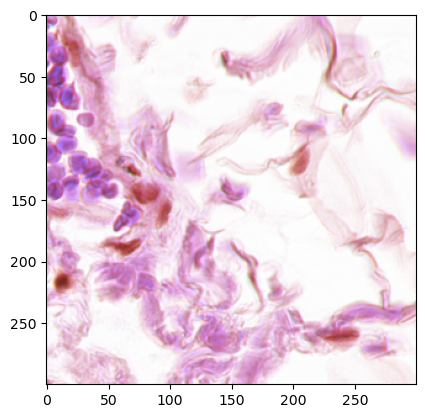

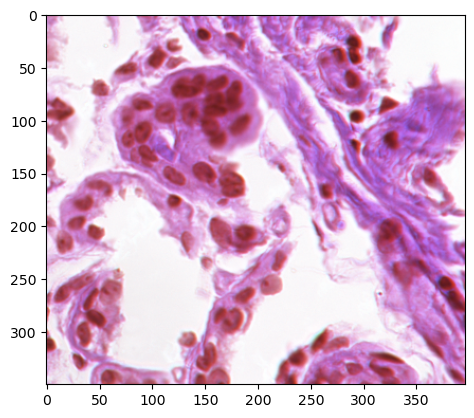

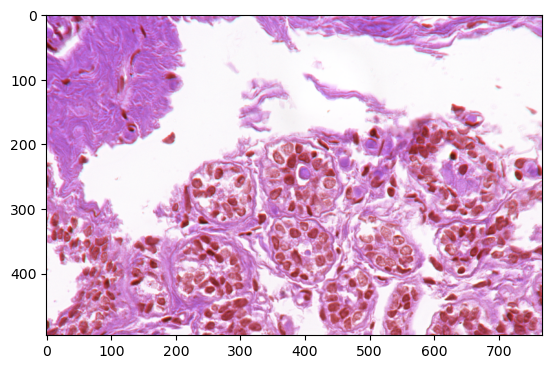

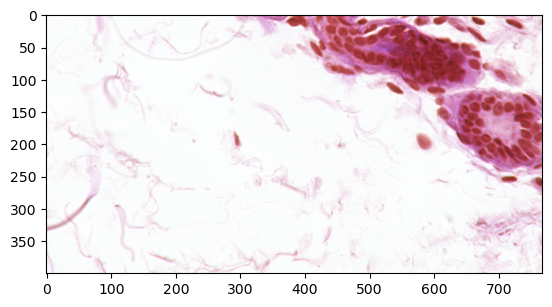

In [23]:
# load image
import cv2
shapes = []
for path in image_paths[10:14]:
    img_arr = cv2.imread(path)
    plt.imshow(img_arr)
    plt.show()
    shapes.append(list(img_arr.shape))
shapes = np.array(shapes)


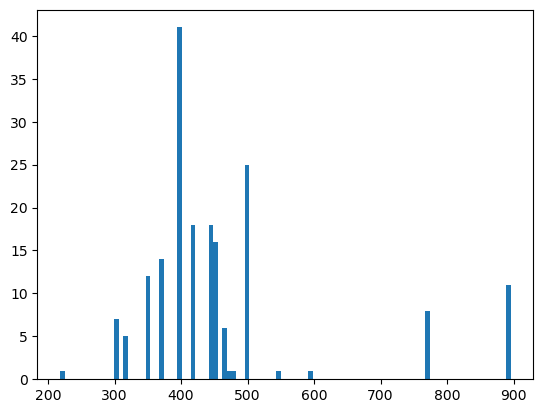

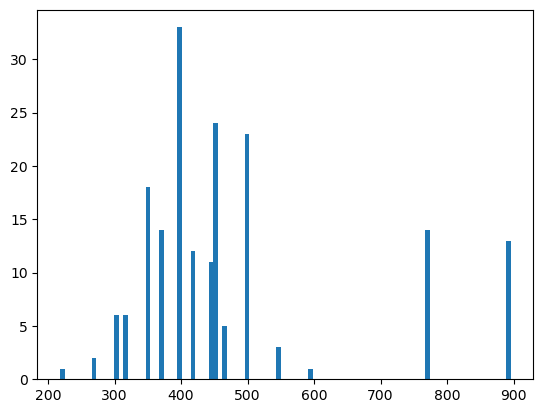

In [27]:
hist = plt.hist(shapes[:, 1], bins=100)
plt.show()
hist = plt.hist(shapes[:, 0], bins=100)
plt.show()

## Create dataset

In [24]:
import PIL
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms
from torchvision.io import read_image

In [25]:
# extract training and test set
train_ids = labels_df["id"].tolist()
# train_set_paths = [path for path in image_paths for img_id in train_ids if str(img_id) in path]
train_set_paths = [f"{data_dir}/img_{img_id}.png" for img_id in train_ids]

test_set_paths = list(set(image_paths) - set(train_set_paths))



In [156]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels=None, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = read_image(image_path)
        if self.labels is not None:
            label = self.labels[index]
        else:
            label = np.nan

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [157]:
transform = transforms.Compose(
    [
        
#         transforms.ToImageTensor(), 
#         transforms.ConvertImageDtype(),
        transforms.Resize([224, 224], antialias=True),
        transforms.RandomPhotometricDistort(),
#         transforms.RandomZoomOut(
#             fill=defaultdict(lambda: 0, {PIL.Image.Image: (123, 117, 104)})
#         ),
#         transforms.RandomIoUCrop(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
#         transforms.AugMix(),
#         transforms.ToImageTensor(),
#         transforms.ConvertImageDtype(torch.float32),
#         transforms.SanitizeBoundingBox(),
    ]
)

In [158]:
train_set = CustomDataset(train_set_paths, labels=labels_df["malignant"].tolist(), transform=transforms.Resize([224, 224], antialias=True))
train_set_modified = CustomDataset(train_set_paths, labels=labels_df["malignant"].tolist(), transform=transform)
test_set = CustomDataset(test_set_paths, labels=None, transform=transforms.Resize([224, 224], antialias=True))

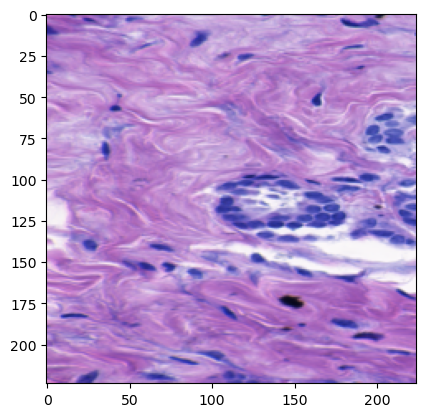

In [159]:
# plt.imshow(train_set[20][0].permute(1, 2, 0).numpy())
plt.imshow(test_set[20][0].permute(1, 2, 0).numpy())

In [74]:
len(train_set)

62

In [160]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4, drop_last=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)

## Define model pipeline

In [1]:
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights, convnext_base, convnext_large, ConvNeXt_Large_Weights, ConvNeXt_Base_Weights
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision.models as models

### Load pretrained model

In [162]:
# Step 1: Initialize model with the best available weights
# weights = ConvNeXt_Base_Weights.DEFAULT
# model = convnext_base(weights=weights)
weights = ConvNeXt_Large_Weights.DEFAULT
model = convnext_large(weights=weights)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms(antialias=True)

In [163]:
img = train_set[10][0]

# Step 3: Apply inference preprocessing transforms
batch = preprocess(img).unsqueeze(0)

# Step 4: Use the model and print the predicted category
prediction = model(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

nematode: 48.6%


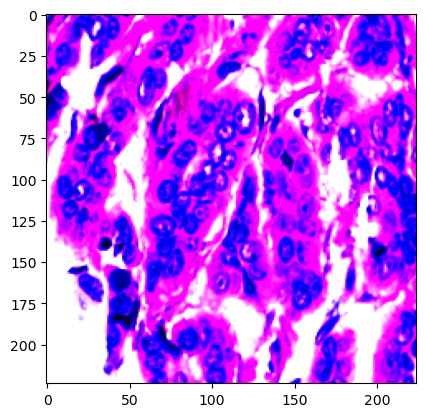

In [164]:
plt.imshow(batch.squeeze(0).permute(1, 2, 0).numpy())

### Fine tune model

### Compute feature vectors

In [165]:
# train_nodes, eval_nodes = get_graph_node_names(resnet50())
# train_nodes, eval_nodes = get_graph_node_names(convnext_base())

# print(eval_nodes)
# print(train_nodes)
return_nodes = {
#     "flatten": "out_features"
    "classifier.1": "out_features"
#     "avgpool": "out_features"
}
feature_extractor = create_feature_extractor(model, return_nodes=return_nodes)

In [166]:
feature_extractor(batch)["out_features"].shape

torch.Size([1, 1536])

### Train classifier

In [167]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score
import itertools

### Extracted feature train and test set

In [168]:
# start with simple sklearn classifier
num_samples_target = 62
X_train = []
y_train = []
feature_extractor.eval()
num_samples_current = 0
for batch in itertools.cycle(train_loader):
    X_train.append(feature_extractor(preprocess(batch[0]))["out_features"].detach().numpy())
    y_train.append(batch[1].detach().numpy())
    num_samples_current += X_train[-1].shape[0]
    if num_samples_current >= num_samples_target:
        break
X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)
print(X_train.shape)

(62, 1536)


In [169]:
X_test = []
feature_extractor.eval()
for batch in test_loader:
    X_test.append(feature_extractor(preprocess(batch[0]))["out_features"].detach().numpy())
X_test = np.concatenate(X_test)
print(X_test.shape)

(124, 1536)


### Trivial train and test set

In [177]:
gray_scale = transforms.Grayscale()

X_train = np.concatenate([gray_scale(img[0]).numpy().flatten()[None, :] for img in train_set])
y_train = np.array([img[1] for img in train_set])
print(X_train.shape)
X_test = np.concatenate([gray_scale(img[0]).numpy().flatten()[None, :] for img in test_set])
print(X_test.shape)

(62, 50176)
(124, 50176)


## Train and test the model

In [178]:
steps = [
    ('scaler', StandardScaler()),  # Example step for data scaling
    ('classifier', SVC(class_weight='balanced'))  # Example step for classification
]

# Create the pipeline
pipeline = Pipeline(steps)

# pipeline.fit(X_train, y_train)

# Define the scoring metric (F1 score)
scorer = make_scorer(f1_score, average="macro")

# Evaluate the pipeline using cross-validation and mean F1 score
scores = cross_val_score(pipeline, X_train[0:62], y_train[0:62], cv=5, scoring=scorer)
mean_f1 = np.mean(scores)
print("Scores:", scores)
print(f"Mean F1 score: {mean_f1}")

Scores: [0.59259259 0.22857143 0.40196078 0.22222222 0.22222222]
Mean F1 score: 0.33351384998443817


In [179]:
pipeline.fit(X_train, y_train)
y_train_pred = pipeline.predict(X_train)
y_train_pred

array([-1, -1,  1, -1, -1,  0,  0,  0,  0,  0, -1,  1,  0, -1,  0,  0, -1,
        0, -1,  1, -1,  1,  1,  0, -1, -1, -1,  1, -1, -1,  1, -1, -1,  1,
       -1, -1, -1,  0,  0,  1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,
        1, -1, -1, -1,  1, -1, -1, -1,  0, -1, -1])

In [180]:
f1_score(y_train, y_train_pred, average="macro")

1.0

In [181]:
y_pred = pipeline.predict(X_test)
y_pred

array([ 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1,
       -1, -1, -1,  1, -1,  0, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1,
       -1, -1,  1,  1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1,  1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1,
       -1, -1,  1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1,  1, -1, -1, -1,
       -1,  0, -1, -1, -1])

## Create submission file

In [182]:
# get test set ids
ids = [path.split(".")[0].split("_")[-1] for path in test_set.image_paths]
submission_df = pd.DataFrame({
    "id": ids,
    "malignant": y_pred,
})
submission_df.to_csv("submission.csv", index=False)
submission_df

,id,malignant
0,367735,0
1,531231,-1
2,769175,-1
3,997841,-1
4,240314,-1
...,...,...
119,376611,-1
120,136044,0
121,819075,-1
122,139077,-1


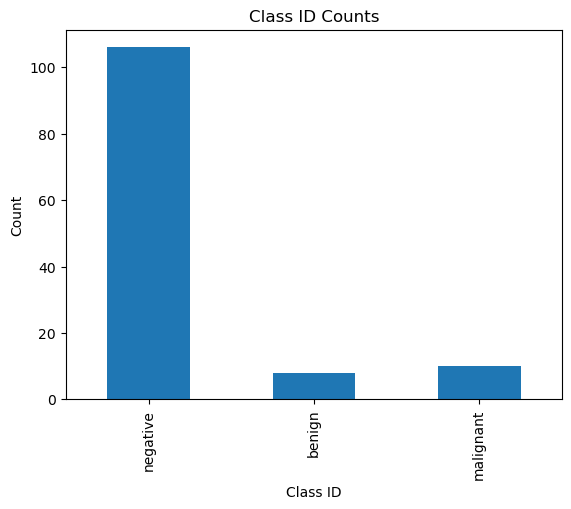

In [183]:
# show label distribution
expanded_df = pd.get_dummies(submission_df['malignant'])
# rename columns
expanded_df.columns = ["negative", "benign", "malignant"]
class_counts = expanded_df.iloc[:, 0:].sum()

# Plot the bar plot
class_counts.plot(kind='bar')

# Set labels and title
plt.xlabel('Class ID')
plt.ylabel('Count')
plt.title('Class ID Counts')

# Show the plot
plt.show()

In [63]:
import pathlib
pathlib.Path().resolve()

PosixPath('/kaggle/working')